# Pricing Test Data Challenge

## Goal
Pricing optimization is, non surprisingly, another area where data science can provide huge value.

The goal here is to evaluate whether a pricing test running on the site has been successful. As always, you should focus on user segmentation and provide insights about segments who behave differently as well as any other insights you might find.

***

## Challenge Description

Company XYZ sells a software for \\$39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price (\\$39), while a random sample of 33% users a higher price (\$59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

Especially he asked you the following questions:
<li>
<b>Should the company sell its software for \$39 or \$59?</b>

<li>
The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. <b>What are your main findings looking at the data?</b>

<li>
[Bonus] The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? <b>After how many days you would have stopped the test? Please, explain why.</b>


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from numpy.random import seed
from scipy.stats import norm
from scipy.stats import t
import seaborn as sns

%matplotlib inline

In [2]:
# load and integrate data

test_results = pd.read_csv('test_results.csv')
user_table = pd.read_csv('user_table.csv')

### Data Wrangling and EDA

In [3]:
data = test_results.merge(user_table, left_on = 'user_id',right_on = 'user_id')
data.head()

user_id            timestamp          source  device operative_system  \
0   604839  2015-05-08 03:38:34    ads_facebook  mobile              iOS   
1   624057  2015-05-10 21:08:46      seo-google  mobile          android   
2   317970  2015-04-04 15:01:23        ads-bing  mobile          android   
3   685636  2015-05-07 07:26:01  direct_traffic  mobile              iOS   
4   820854  2015-05-24 11:04:40    ads_facebook     web              mac   

   test  price  converted          city country    lat   long  
0     0     39          0       Buffalo     USA  42.89 -78.86  
1     0     39          0     Lakeville     USA  44.68 -93.24  
2     0     39          0         Parma     USA  41.38 -81.73  
3     1     59          0  Fayetteville     USA  35.07 -78.90  
4     0     39          0       Fishers     USA  39.95 -86.02

In [4]:
# modify timestamp values that exceeds 60 which is not accepted to be a valid datetime value. 
# Assuming modify 1-2 minute would not affect information
data['timestamp'] = data['timestamp'].apply(lambda x: x.replace(':60',':59'))

In [5]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275616 entries, 0 to 275615
Data columns (total 12 columns):
user_id             275616 non-null int64
timestamp           275616 non-null datetime64[ns]
source              275616 non-null object
device              275616 non-null object
operative_system    275616 non-null object
test                275616 non-null int64
price               275616 non-null int64
converted           275616 non-null int64
city                275616 non-null object
country             275616 non-null object
lat                 275616 non-null float64
long                275616 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 27.3+ MB


In [7]:
# check feature distribution

numeric_columns = ['user_id']
cat_columns = ['source', 'device', 'operative_system',  'country','city','price', 'converted']

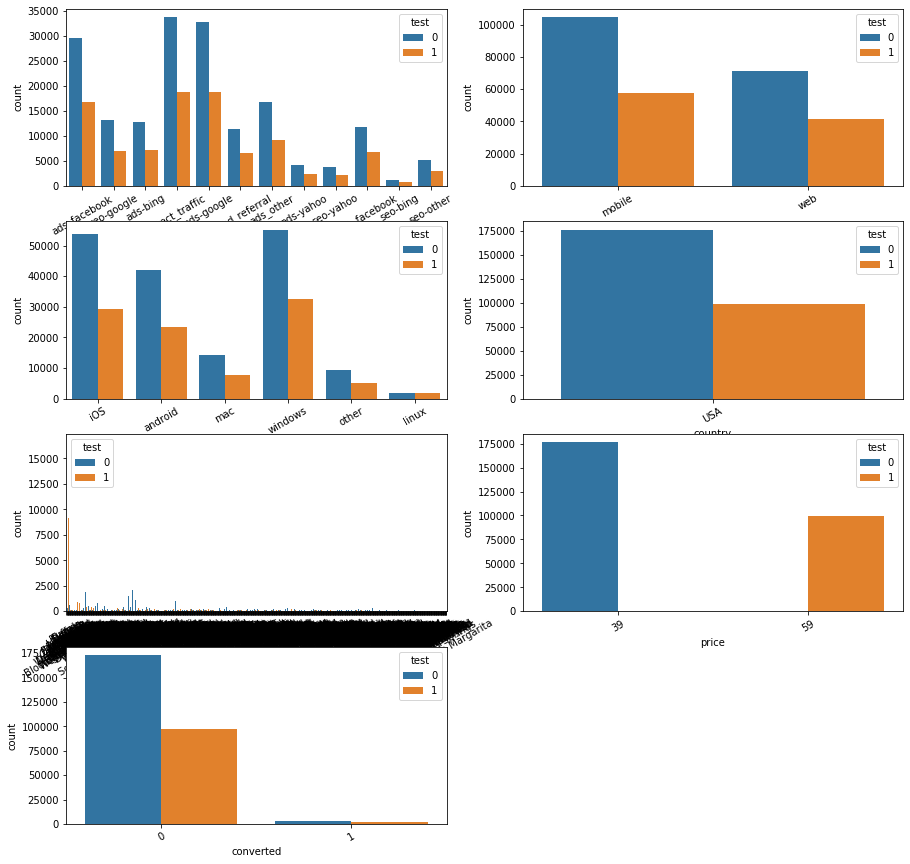

In [115]:
# plot value count for each categorical feature 
# using hue to see whether testing group has similar distribution pattern with control group
fig1 = plt.figure(figsize=(15,15))
i = 1
for col in cat_columns:
    ax = fig1.add_subplot(4,2,i)
    sns.countplot(data=data, x=col,hue = 'test', ax=ax)
    ax.set_xlabel(col)
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=30)
    i += 1

In [62]:
# checking whether users are unique
len(data['user_id'].unique()), data.shape

(275616, (275616, 12))

### Findings from above:
<li>
    There is only contry: USA involved in the study, so no need to consider this feature. </li>
<li>
    Sample in both groups: test group and control group is randomly distributed, no obvious vialation in randomness.
</li>

In [6]:
# set time as index
df = data[['user_id', 'timestamp', 'source', 'device', 'operative_system', 'test',
       'price', 'converted', 'city']].set_index(data['timestamp'])

In [201]:
# split two groups

In [9]:
# check whether price match with testing group
from collections import Counter
Counter(zip(df['test'],df['price']))

Counter({(0, 39): 176241, (1, 59): 99053, (1, 39): 135, (0, 59): 187})

In [7]:
# drop the cases that price doesn't math with price
control = df.loc[(df['test']==0) & (df['price']==39)]
test = df.loc[(df['test']==1) & (df['price']==59)]

In [17]:
test.shape, control.shape

((99053, 9), (176241, 9))

In [18]:
control['converted'].sum(), test['converted'].sum()

(3484, 1530)

In [205]:
print("convertion rate in control group: {:.4}".format(control['converted'].sum()/control.shape[0]))
print("convertion rate in test group: {:.4}".format(test['converted'].sum()/test.shape[0]))

convertion rate in control group: 0.01977
convertion rate in test group: 0.01545


### Q1: Should the company sell its software for \\$39 or \\$59?
Eventhough increasing price lowered the convertion rate, but it increased profit 
            0.01977*/$39 = 0.771 for control versus 0.01545*/$59 = 0.911 for test
since the price is higher and convertion rate didn't drop too much. Therefore, we need to add a correction factor to the test group with 59/39 = 0.51282, to correct the test conversion rate to 0.02337.


### Is the convertion rate difference statistically significant?
<li>
    Our null hypothesis is the test convertion rate is not better than the control rate. p_t <= p_c.
                                                                                                  
    we calculate z-score first

$$Z = \frac{p_t - p_c}{\sqrt{p_t(1-p_t)/N_t + p_c(1-p_c)/N_c}}$$

    The confidence interval of the convertion rate is (two tail, for one tail, only plus needed)

$$p { \scriptstyle\pm } Z_\alpha*SE $$

    while 
    
$$ SE = \sqrt{p(1-p)/N}$$

<br>
<li>
    We calculate sample size that required for one tail test to see a significant change. $\alpha$ is usually 0.05 and $\beta$ is usually 0.2
    
$$ N = \frac{(Z_\alpha - Z_{1-\beta})^2(p_t(1-p_t) + p_c(1-p_c))}{(p_t-p_c)^2}$$


In [22]:
def cal_z(p_t,p_c,Nt,Nc):
    return (p_t - p_c)/np.sqrt((p_t*(1-p_t)/Nt) + (p_c*(1-p_c)/Nc))

def cal_n(Za,Z1_b,p_t,p_c):
    return ((Za - Z1_b)**2)*(p_t*(1-p_t) + p_c*(1-p_c))/(p_t - p_c)**2

def cal_se(p,N):
    return np.sqrt(p*(1-p)/N)

In [23]:
# Z-test
p_t = 0.01545
correct = 59/39
p_c = 0.01977
p_t = p_t*correct

Nt = 99053
Nc = 176241

Za = norm.ppf(0.95)
Z1_b = norm.ppf(0.8)

margin = Za*cal_se(p_c,Nc)
Z = cal_z(p_t,p_c,Nt,Nc)
N = cal_n(Za,Z1_b,p_t,p_c)

In [24]:
round(N,0),round(Z,4),(p_c,p_c+margin)

(2098.0, 6.1755, (0.01977, 0.020315432625754498))

<li>The Z score is 6.1755, which is much higher than the $Z_{alpah0.05} = 1.645$,  Therefore, <b>the result is statistically significant</b>.</li>

<li>The confidence interval for control convertion rate is 0.01977 + margin = (0.01977, 0.02031), and the corrected conversion rate is 0.02337, which is higher than the right margin of the control, therefore, in another way, <b>the result is statistically significant</b>.

<li>Acutually, the sample size 99053 is much higher than required sample size to calculate significance, which is only 2098 needed, as calculated by above N.</li>

### Q2: Holistic view of user behavior

In [184]:
# time series view for user activity

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 275616 entries, 2015-05-08 03:38:34 to 2015-03-08 17:12:33
Data columns (total 9 columns):
user_id             275616 non-null int64
timestamp           275616 non-null datetime64[ns]
source              275616 non-null object
device              275616 non-null object
operative_system    275616 non-null object
test                275616 non-null int64
price               275616 non-null int64
converted           275616 non-null int64
city                275616 non-null object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 21.0+ MB


### User activity along time

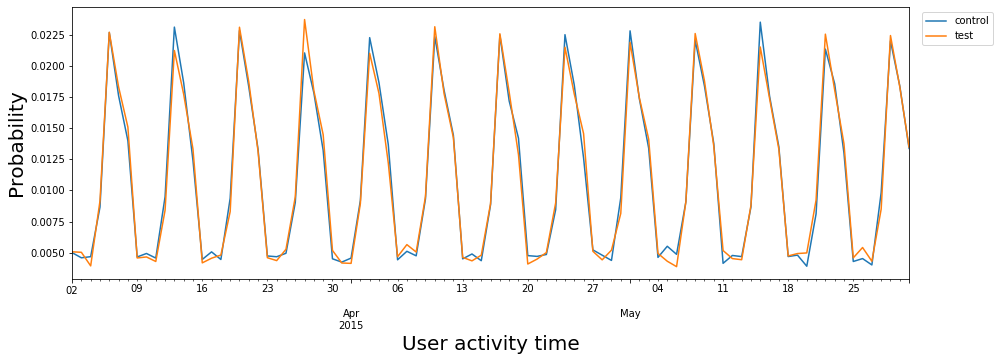

In [223]:
# over-all view in days
control_d = control.resample('1d')['user_id'].count()/Nc
test_d = test.resample('1d')['user_id'].count()/Nt

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
control_d.plot(ax=ax, label='control')
test_d.plot(ax=ax,label='test')

plt.ylabel('Probability',fontsize=20)
plt.xlabel('User activity time', fontsize=20)
plt.legend(bbox_to_anchor=(1.01, 1))

Very periodical weekly pattern.

(23829120, 23849280)

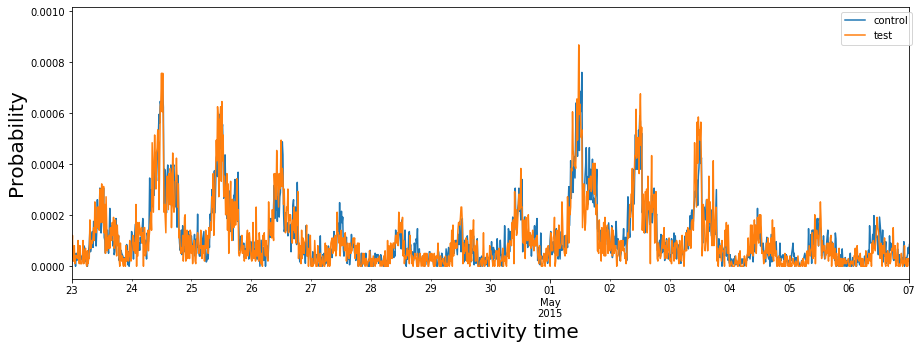

In [228]:
# over-all view within a day for 2 weeks
control_d = control.resample('15min')['user_id'].count()/Nc
test_d = test.resample('15min')['user_id'].count()/Nt

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
control_d.plot(ax=ax, label='control')
test_d.plot(ax=ax,label='test')

plt.ylabel('Probability',fontsize=20)
plt.xlabel('User activity time', fontsize=20)
plt.legend(bbox_to_anchor=(1.01, 1))
plt.xlim(['2015-04-23','2015-05-07'])

Strong weekend peaks: Peak days are Friday(24,1), Saturday(25,2) and Sunday(26,3)

(23830560, 23833440)

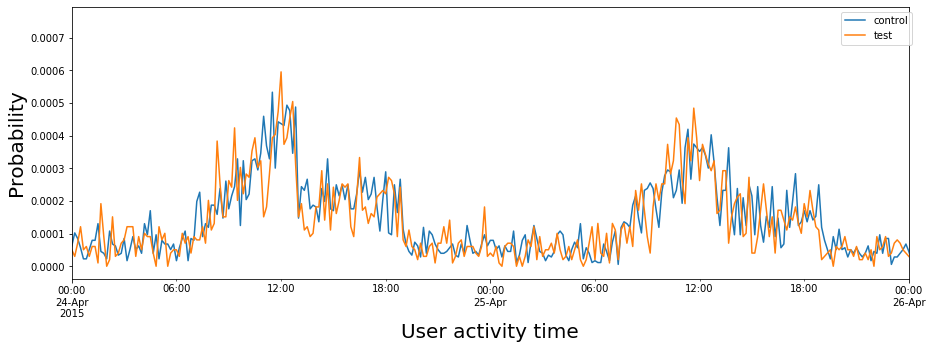

In [233]:
# over-all view within a day for 2 days during weekend
control_d = control.resample('10min')['user_id'].count()/Nc
test_d = test.resample('10min')['user_id'].count()/Nt

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
control_d.plot(ax=ax, label='control')
test_d.plot(ax=ax,label='test')

plt.ylabel('Probability',fontsize=20)
plt.xlabel('User activity time', fontsize=20)
plt.legend(bbox_to_anchor=(1.01, 1))
plt.xlim(['2015-04-24','2015-04-26'])

peak at noon (12:00)

### Convertion rate over time

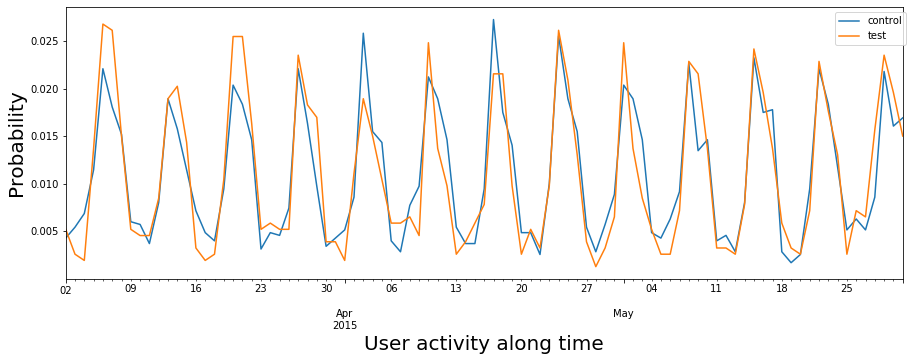

In [242]:
# over-all view in days
control_d = control.resample('1d')['converted'].sum()/(Nc*p_c) # normalized convertion probability for control
test_d = test.resample('1d')['converted'].sum()/(Nt*p_t)*correct # normalized and corrected convertion rate for test

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
control_d.plot(ax=ax, label='control')
test_d.plot(ax=ax,label='test')

plt.ylabel('Probability',fontsize=20)
plt.xlabel('User activity along time', fontsize=20)
plt.legend(bbox_to_anchor=(1.01, 1))

(23829120, 23849280)

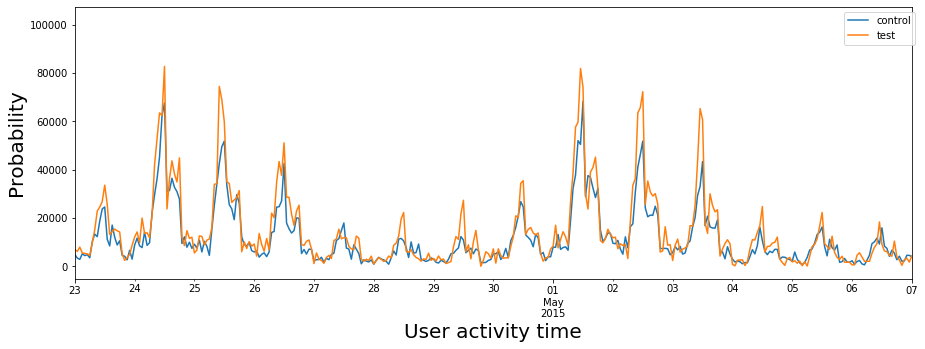

In [243]:
# over-all view within a day for 2 weeks
control_d = control.resample('60min')['user_id'].sum()/(Nc*p_c)
test_d = test.resample('60min')['user_id'].sum()/(Nt*p_t)*correct

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
control_d.plot(ax=ax, label='control')
test_d.plot(ax=ax,label='test')

plt.ylabel('Probability',fontsize=20)
plt.xlabel('User activity time', fontsize=20)
plt.legend(bbox_to_anchor=(1.01, 1))
plt.xlim(['2015-04-23','2015-05-07'])

(23830560, 23833440)

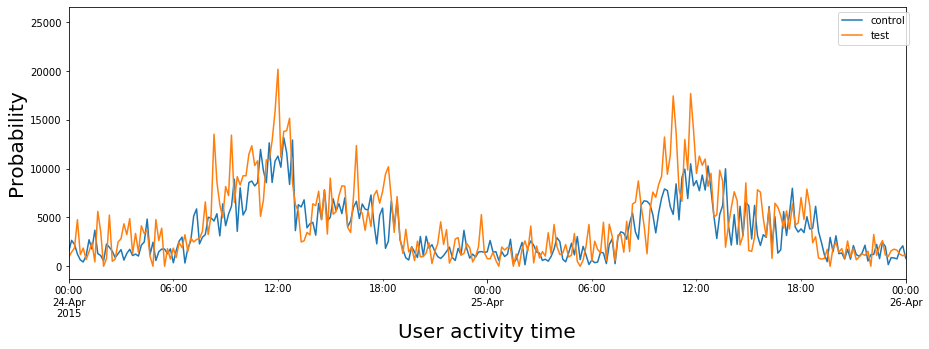

In [244]:
# over-all view within a day for 2 days during weekend
control_d = control.resample('10min')['user_id'].sum()/(Nc*p_c)
test_d = test.resample('10min')['user_id'].sum()/(Nt*p_t)*correct

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
control_d.plot(ax=ax, label='control')
test_d.plot(ax=ax,label='test')

plt.ylabel('Probability',fontsize=20)
plt.xlabel('User activity time', fontsize=20)
plt.legend(bbox_to_anchor=(1.01, 1))
plt.xlim(['2015-04-24','2015-04-26'])

Strong correlation of convertion rate with user activity

### Convertion rate for each feature

In [16]:
columns = ['source', 'device', 'operative_system', 'city']

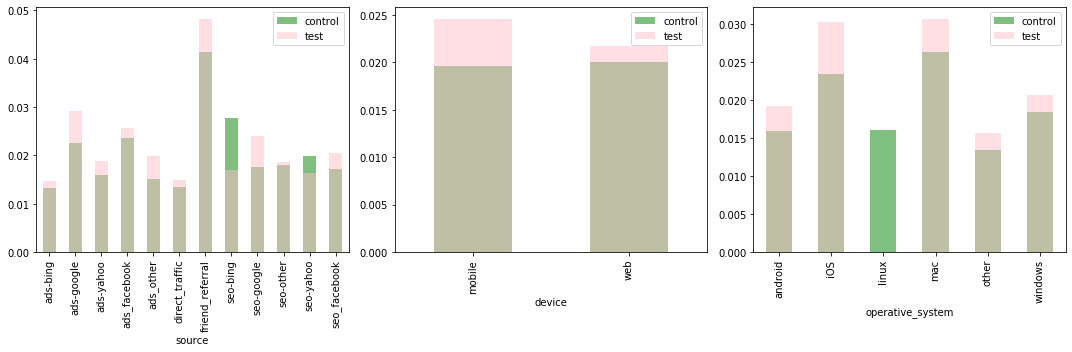

In [286]:
# plot value count for each categorical feature 
# using hue to see whether testing group has similar distribution pattern with control group
fig = plt.figure(figsize=(15,5))
i = 1
for col in columns[:-1]:
    ax = fig.add_subplot(1,3,i)
    
    control[[col, 'converted']].groupby(col).mean().plot(kind='bar',ax=ax,label='control',color='green',alpha=0.5)
    test[[col, 'converted']].groupby(col).mean().apply(lambda x: x*correct).plot(kind='bar',ax=ax,\
                                                                                 label='test',color='pink',alpha=0.5)
    
    plt.legend(('control','test'))
    ax.set_xlabel(col)
    plt.tight_layout()

    i += 1

<li>Friend_referral has highest convertion rate for both control and test as a source
<li>Mobile device get higher convertion rate in test than in control.
<li>iOS amd mac have higher convertion rate both in test and control.
<li>For most platforms, test has higher convertion rate than control, except for 'seo-bing' in 'source' feature and 'linux' in 'operative_system' feature.

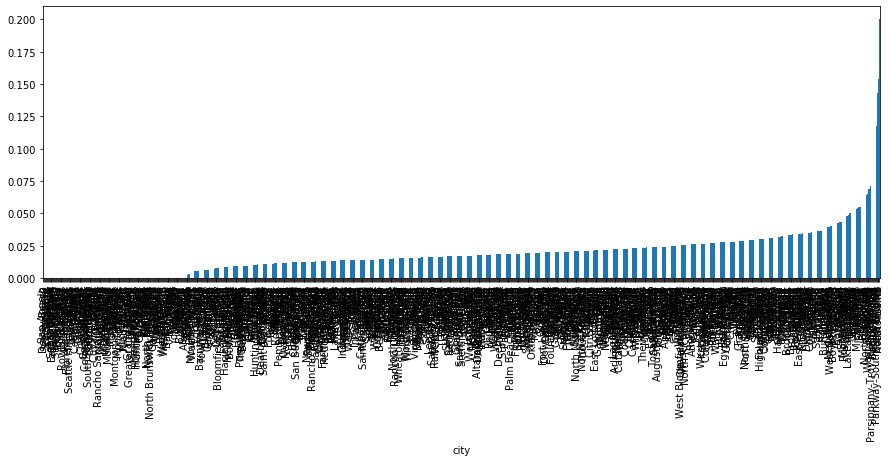

In [27]:
# plot city feature
fig,ax = plt.subplots(figsize=(15,5))
city_convert = df[['city', 'converted']].groupby('city').mean().sort_values(by='converted')
city_convert.plot(kind='bar',legend=False,ax=ax)

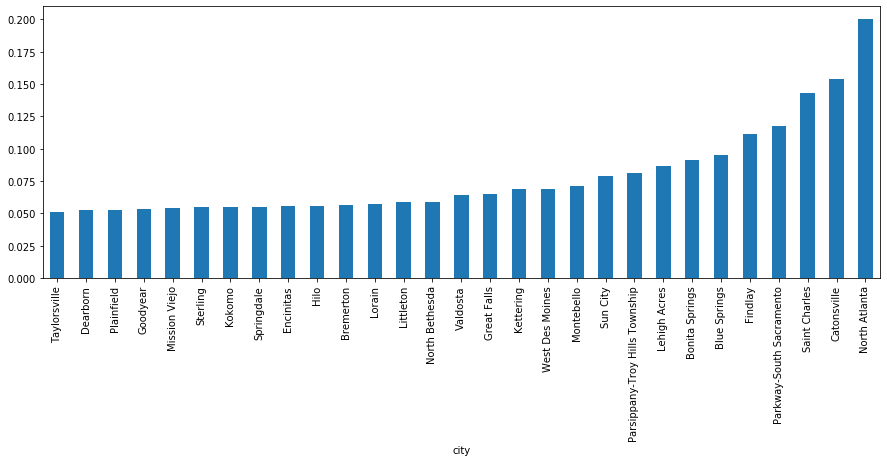

In [28]:
# too many cities, separate them into different buckets
# first buckets: high rates
fig,ax = plt.subplots(figsize=(15,5))
city_convert.loc[city_convert['converted'] > 0.05].plot(kind='bar',legend=False,ax=ax)

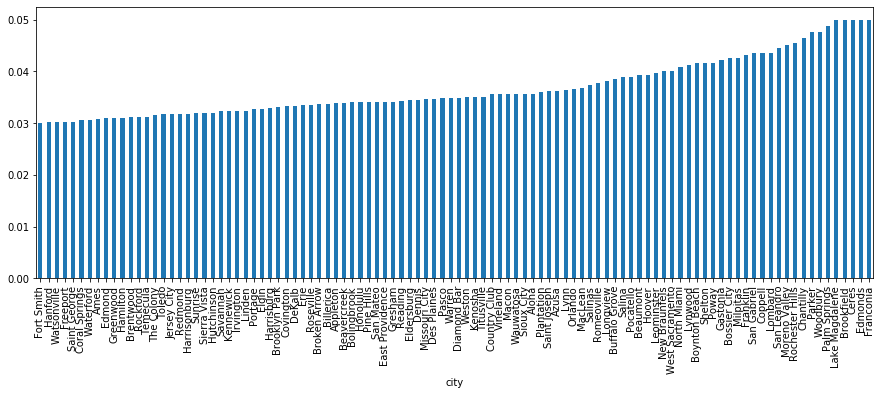

In [29]:
# second buckets: upper middle rate
fig,ax = plt.subplots(figsize=(15,5))
city_convert.loc[(city_convert['converted']>0.03) & (city_convert['converted']<=0.05)].plot(\
                                                                        kind='bar',legend=False,ax=ax)

In [8]:
# group cities to clusters according to geomatric distance

from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score

In [9]:
# we choose 50 clusters since there are 50 states in USA

km_cluster = KMeans(n_clusters=50).fit(df[['lat','long']])


In [17]:
df['cluster'] = km_cluster.labels_

In [19]:
df.head()

user_id           timestamp          source  device  \
timestamp                                                                  
2015-05-08 03:38:34   604839 2015-05-08 03:38:34    ads_facebook  mobile   
2015-05-10 21:08:46   624057 2015-05-10 21:08:46      seo-google  mobile   
2015-04-04 15:01:23   317970 2015-04-04 15:01:23        ads-bing  mobile   
2015-05-07 07:26:01   685636 2015-05-07 07:26:01  direct_traffic  mobile   
2015-05-24 11:04:40   820854 2015-05-24 11:04:40    ads_facebook     web   

                    operative_system  test  price  converted          city  \
timestamp                                                                    
2015-05-08 03:38:34              iOS     0     39          0       Buffalo   
2015-05-10 21:08:46          android     0     39          0     Lakeville   
2015-04-04 15:01:23          android     0     39          0         Parma   
2015-05-07 07:26:01              iOS     1     59          0  Fayetteville   
2015-05-24 11:04:40              mac     0     39          0       Fishers   

                     cluster  
timestamp                     
2015-05-08 03:38:34       27  
2015-05-10 21:08:46       28  
2015-04-04 15:01:23       44  
2015-05-07 07:26:01       30  
2015-05-24 11:04:40        9

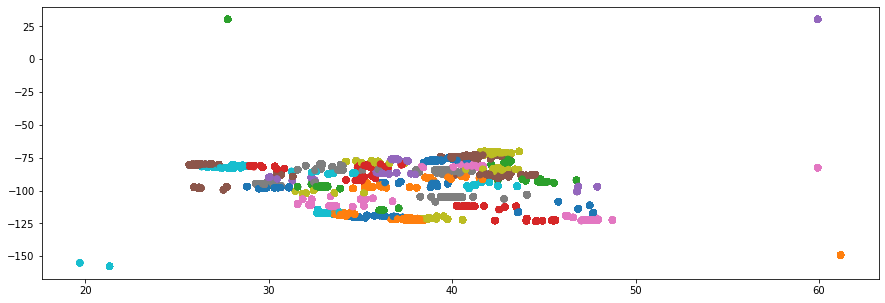

In [316]:
# 50 clusters
fig = plt.figure(figsize=(15,5))

color_seq = ['C'+str(i) for i in range(50)]
colors = cities['cluster'].map(lambda x: color_seq[x])
plt.scatter(cities['lat'],cities['long'],c=colors)

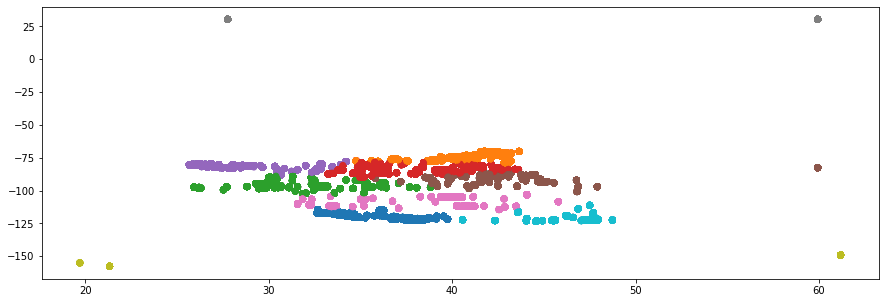

In [309]:
# 10 clusters
fig = plt.figure(figsize=(15,5))
km_cluster = KMeans(n_clusters=10).fit(cities[['lat','long']])
cities['cluster'] = km_cluster.labels_

color_seq = ['C'+str(i) for i in range(50)]
colors = cities['cluster'].map(lambda x: color_seq[x])
plt.scatter(cities['lat'],cities['long'],c=colors)

In [ ]:
"""
Optimize clusters if needed:

from sklearn.metrics import silhouette_score
SSE = []
K = range(10,50,5)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    
    score = silhouette_score(cities[['lat','long']], kmeanModel.fit_predict(cities[['lat','long']]))
    print(datetime.now(),': ',score)
    SSE.append(score)
    
plt.plot(K,SSE)
"""

In [20]:
# drop the cases that price doesn't math with price
control = df.loc[(df['test']==0) & (df['price']==39)]
test = df.loc[(df['test']==1) & (df['price']==59)]

Text(0, 0.5, 'user activity probability')

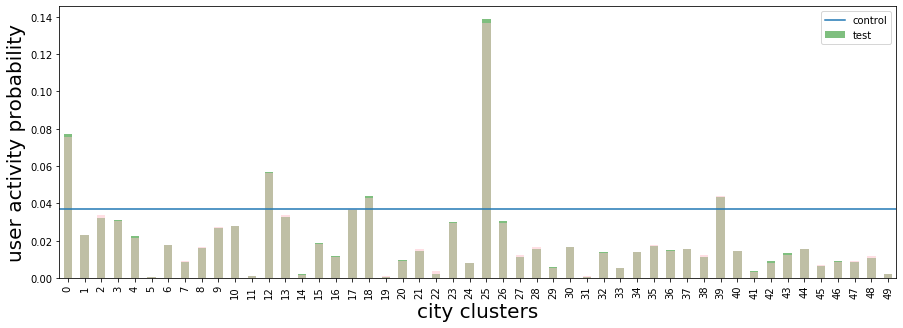

In [49]:
# user activity
col = 'cluster'

fig, ax = plt.subplots(figsize=(15,5))
control[[col, 'converted']].groupby(col).count().apply(lambda x: x/Nc).plot(kind='bar',ax=ax,\
                                                                            label='control',color='green',alpha=0.5)
test[[col, 'converted']].groupby(col).count().apply(lambda x: x/Nt).plot(kind='bar',ax=ax,\
                                                                        label='test',color='pink',alpha=0.5)
plt.axhline(0.037)
plt.legend(('control','test'))
plt.xlabel('city clusters',fontsize=20)
plt.ylabel('user activity probability',fontsize=20)

top 5 clusters: 0, 12, 18, 25, 39, with 25 has the highest user activity

Text(0, 0.5, 'user activity probability')

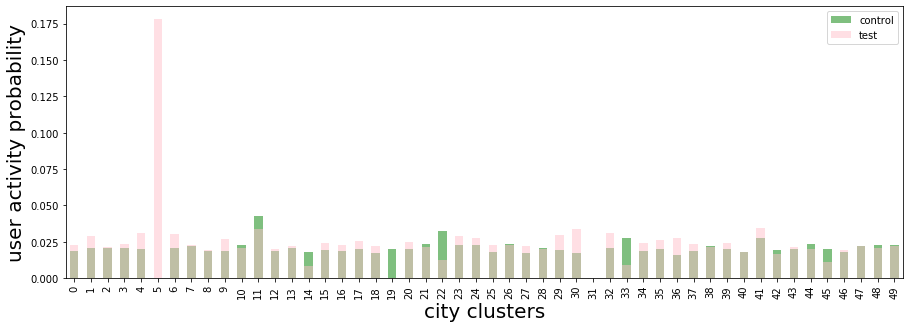

In [45]:
# plot convertion rate according to city clusters
fig,ax = plt.subplots(figsize=(15,5))

control[['cluster','converted']].groupby('cluster').mean().plot(kind='bar',ax=ax,label='control',\
                                                                color='green',alpha=0.5)
test[['cluster', 'converted']].groupby('cluster').mean().apply(lambda x: x*correct).plot(kind='bar',ax=ax,\
                                                                                 label='test',color='pink',alpha=0.5)
plt.legend(('control','test'))
plt.xlabel('city clusters',fontsize=20)
plt.ylabel('user activity probability',fontsize=20)

Cluster 5 has the most convertion rate in test group.
Explore cluster 5

In [30]:
df.loc[df['cluster']==5].city.unique()

array(['Saint Petersburg'], dtype=object)

In [32]:
# explore all clusters
for i in range(50):
    print('cluster {}'.format(i))
    print(df.loc[df['cluster']==i].city.unique())

cluster 0
['Culver City' 'Redondo Beach' 'Garden Grove' 'Arcadia' 'Los Angeles'
 'Westminster' 'Norwalk' 'Thousand Oaks' 'Inglewood' 'Pico Rivera'
 'Anaheim' 'Pomona' 'Fullerton' 'Huntington Park' 'Lancaster' 'Oxnard'
 'Orange' 'East Los Angeles' 'Huntington Beach' 'Long Beach'
 'Santa Barbara' 'Burbank' 'Torrance' 'Santa Ana' 'West Covina'
 'Placentia' 'La Mirada' 'El Monte' 'Santa Monica' 'Glendale'
 'Chino Hills' 'Compton' 'Hawthorne' 'Brea' 'Palmdale' 'Azusa' 'Covina'
 'Chino' 'Alhambra' 'Pasadena' 'Fountain Valley' 'South Gate'
 'South Whittier' 'Diamond Bar' 'Florence-Graham' 'Simi Valley' 'Cypress'
 'Bakersfield' 'Downey' 'Yorba Linda' 'Tulare' 'Buena Park' 'Camarillo'
 'Upland' 'La Puente' 'Altadena' 'Lynwood' 'Carson' 'Bell Gardens'
 'Rancho Palos Verdes' 'Lakewood' 'Glendora' 'Delano' 'Lompoc' 'Visalia'
 'Gardena' 'San Gabriel' 'Baldwin Park' 'Rosemead' 'Monterey Park'
 'Hacienda Heights' 'Paramount' 'Porterville' 'La Habra' 'Costa Mesa'
 'Rowland Heights' 'San Buenaventura' 

['Grand Rapids' 'Fort Wayne' 'Mishawaka' 'Lansing' 'Kalamazoo'
 'Battle Creek' 'Muskegon' 'South Bend' 'East Lansing' 'Elkhart'
 'Kentwood' 'Portage' 'Wyoming']
cluster 47
['Chesterfield' 'Saint Louis' 'Decatur' "O'Fallon" 'Springfield'
 'Florissant' 'Saint Peters' 'Normal' 'Peoria' 'Bloomington' 'Belleville'
 'Saint Charles']
cluster 48
['Milwaukee' 'Sheboygan' 'Green Bay' 'Oshkosh' 'Rockford' 'Appleton'
 'Brookfield' 'Janesville' 'Dubuque' 'Fond du Lac' 'Madison' 'Wauwatosa'
 'West Allis' 'Waukesha']
cluster 49
['Fargo' 'Grand Forks' 'Bismarck']


### A2: Holistic view of user behavior
Explored features:
timestamp  user_id	source	device	operative_system	test	price	converted	city	country	lat	long cluster
<li> Users are more active during weekends, most active during noon </li>
<li> Apple sources have more activity and convertion rate </li>
<li> Mobile deviced has higher convertion rate even with similar user activity </li>
<li> top 5 clusters in user activity: 0, 12, 18, 25, 39, with 25 (NY & NJ) has the highest user activity </li>
<li> convertion rate are similar accross cities, but 'Saint Petersburg' in Florida is special </li>

In [65]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

In [57]:
dfc = pd.concat([control,test])[['source','device','operative_system','converted','city','cluster']]

In [64]:
y = dfc['converted']
X = dfc.drop(columns='converted')

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
def optimize(model, **param, scores):
    """
    optimize model
    param: dictionray of hyper parameters
    score: pandas dataframe to store the best results
    
    """
    score = {}
    

In [ ]:
cls = LGBMClassifier()

### Q3: The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

#### A3: I agree with this intuition, as we shown in Q1, the sample size is much bigger than required. Now we will start the calculated along time when we could have stopped the test earlier

In [50]:
def cal_cr(df):
    return df.converted.sum()/df.shape[0]

In [58]:
dfc.head()

source  device operative_system  converted  \
timestamp                                                               
2015-05-08 03:38:34  ads_facebook  mobile              iOS          0   
2015-05-10 21:08:46    seo-google  mobile          android          0   
2015-04-04 15:01:23      ads-bing  mobile          android          0   
2015-05-24 11:04:40  ads_facebook     web              mac          0   
2015-04-13 12:07:08    ads-google  mobile              iOS          0   

                          city  cluster  
timestamp                                
2015-05-08 03:38:34    Buffalo       27  
2015-05-10 21:08:46  Lakeville       28  
2015-04-04 15:01:23      Parma       44  
2015-05-24 11:04:40    Fishers        9  
2015-04-13 12:07:08   New York       25

In [ ]:
CRA = [] # control
CRB = [] # test

for i in range(df.shape[0]):
    